In the old data-prep pipeline I did not properly scale the data (I scaled all the data at once, rather than applying that same scaling to the train set first, and then apply it to the val/test sets). Thus, I may have had some data leakage. Also, I am getting results that aren't good for the train set. Thus, I wonder if it has all been done properly.

Steps:
- Separate each cut into it's own h5 file (all 167)
- Scale data for train set only, and then apply same transform to val/test set

In [2]:
import numpy as np
import scipy.io as sio
from sklearn.utils import shuffle
import pathlib
import pandas as pd
from pathlib import Path
# from src.func import data_transforms
import matplotlib.pyplot as plt

import h5py
import zipfile

%matplotlib inline
%load_ext autoreload
%autoreload 2

In [4]:
# data_folder = Path(r'C:\_Python\_milling\data\raw') # windows link
data_file = Path('mill.zip') # linux link
# data_file = data_folder / 'mill.zip'

with zipfile.ZipFile(data_file, 'r') as zip_ref:
    zip_ref.extractall('')

# # load the data from the matlab file
# m = sio.loadmat(data_file,struct_as_record=True)

# # store the 'mill' data in a seperate np array
# data = m['mill']

# # store the field names in the data np array in a tuple, l
# l = data.dtype.names

# # create empty dataframe for the labels
# df_labels = pd.DataFrame()

# # get the labels from the original .mat file and put in dataframe
# for i in range(7):
#     # list for storing the label data for each field
#     x = []
    
#     # iterate through each of the unique cuts
#     for j in range(167):
#         x.append(data[0,j][i][0][0])
#     x = np.array(x)
#     df_labels[str(i)] = x

# # add column names to the dataframe
# df_labels.columns = l[0:7]
    
# # create a column with the unique cut number
# df_labels['cut_no'] = [i for i in range(167)]

# df_labels.head()

In [3]:
current_dir = Path.cwd()
processed_data = current_dir.parent.parent / 'src' 
processed_data

PosixPath('/home/tim/Documents/milling/src')

In [4]:
(X_train, y_train, 
X_train_slim, y_train_slim,
X_val, y_val,
X_val_slim, y_val_slim,
X_test,y_test) = data_transforms.load_train_test(processed_data) 

In [5]:
X_train.shape

(8320, 64, 6)

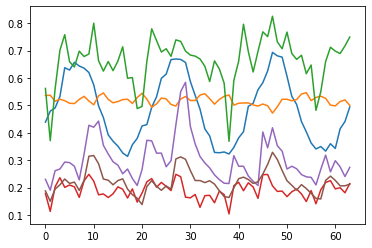

In [6]:
plt.plot(X_train[0])

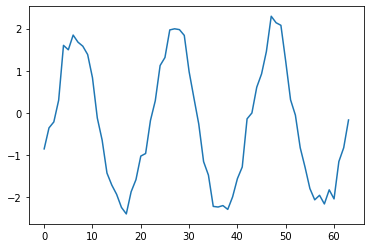

In [7]:
test_signal = X_train[0,:,0]
plt.plot(test_signal)

In [8]:
# s, _, sub_s = np.shape(X_train)
# print(np.shape(X_train))
# print(s,sub_s)

# for i in range(s):
#     for j in range(sub_s):
#         X_train[i,:,j] = np.interp(X_train[i,:,j], (min_vals[j], max_vals[j]), (0, 1))

In [9]:
def scaler(x, min_val_array, max_val_array, lower_norm_val, upper_norm_val):
    
    # get the shape of the array
    s, _, sub_s = np.shape(x)
    
    for i in range(s):
        for j in range(sub_s):
            x[i,:,j] = np.interp(x[i,:,j], 
                                 (min_val_array[j], max_val_array[j]), 
                                 (lower_norm_val, upper_norm_val))
            
    return x
    
def get_min_max(x):

    # flatten the input array http://bit.ly/2MQuXZd
    flat_vector = np.concatenate(x)

    min_vals = np.min(flat_vector,axis=0)
    max_vals = np.max(flat_vector,axis=0)

    return min_vals, max_vals


In [10]:
min_vals, max_vals = get_min_max(X_train)
print(min_vals)
print(max_vals)

X_sample = X_train[0:2]
X_sample = scaler(X_sample, min_vals, max_vals, 0, 1)


[-6.27441406e+00  1.29882812e+00  4.88281250e-02  2.13623047e-01
  1.22070312e-02 -3.66210938e-03]
[6.08398438 9.99511719 3.13476562 2.19116211 0.61218262 0.97900391]


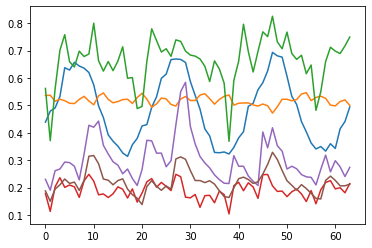

In [11]:
plt.plot(X_sample[0])

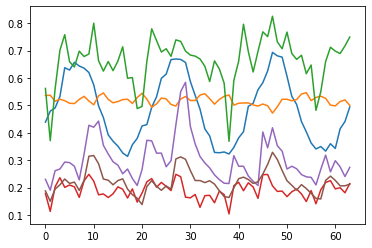

In [12]:
plt.plot(X_train[0])

However, there is a problem when the signal is out of the lower/upper scaling range:

[0.0545239  0.09971926 0.01044304 0.00185185 0.02197355 0.05776398]
[0.54061636 0.6        0.43101266 0.43148148 0.45350966 0.6       ]


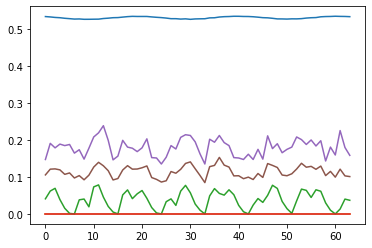

In [17]:
X_val = scaler(X_val, min_vals, max_vals, 0, 0.6)
min_vals_validation, max_vals_validation = get_min_max(X_val)
print(min_vals_validation)
print(max_vals_validation)

X_sample = scaler(X_val, min_vals, max_vals, 0, 1)
plt.plot(X_sample[0])

## Make scaler that doesn't truncate

In [44]:
(X_train, y_train, 
X_train_slim, y_train_slim,
X_val, y_val,
X_val_slim, y_val_slim,
X_test,y_test) = data_transforms.load_train_test(processed_data) 

In [37]:
def scaler(x, min_val_array, max_val_array):
    
    # get the shape of the array
    s, _, sub_s = np.shape(x)
    
    for i in range(s):
        for j in range(sub_s):
            x[i,:,j] = np.divide((x[i,:,j] - min_val_array[j]), np.abs(max_val_array[j] - min_val_array[j]))
           
    return x
    

In [45]:
min_vals, max_vals = get_min_max(X_train)
print(min_vals)
print(max_vals)

X_sample = X_train
X_sample = scaler(X_sample, min_vals, max_vals)

[-6.27441406e+00  1.29882812e+00  4.88281250e-02  2.13623047e-01
  1.22070312e-02 -3.66210938e-03]
[6.08398438 9.99511719 3.13476562 2.19116211 0.61218262 0.97900391]


In [46]:
min_vals, max_vals = get_min_max(X_sample)
print(min_vals)
print(max_vals)

[0. 0. 0. 0. 0. 0.]
[1. 1. 1. 1. 1. 1.]


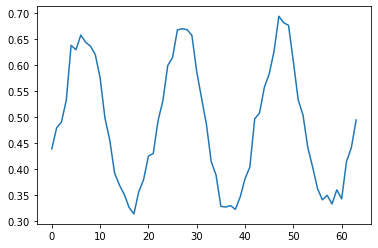

In [39]:
X_sample = X_train[0,:,0]
plt.plot(X_sample)

In [43]:
X_val = scaler(X_test, min_vals, max_vals)

min_vals_validation, max_vals_validation = get_min_max(X_val)
print(min_vals_validation)
print(max_vals_validation)

[-0.05610431  0.00168445  0.00316456  0.01049383  0.14242116  0.11242236]
[1.05610431 1.         0.90585443 0.81851852 1.19837233 1.27515528]


# Make train/val/test set lists

In [69]:
df_labels = pd.read_csv('labels_with_tool_class.csv',index_col=False)
df_labels.head()

,case,run,VB,time,DOC,feed,material,cut_no,tool_class,window_start,window_end
0,1,1,0.00,2,1.5,0.5,1,0,0,2496,6976
1,1,2,NaN,4,1.5,0.5,1,1,0,2496,6976
2,1,3,NaN,6,1.5,0.5,1,2,0,2496,6976
3,1,4,0.11,7,1.5,0.5,1,3,0,2496,6976
4,1,5,NaN,11,1.5,0.5,1,4,0,2496,6976


In [94]:
cut_numbers = np.arange(0,167)
cut_numbers

array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
        26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
        39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
        52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
        65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
        78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
        91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
       104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116,
       117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129,
       130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142,
       143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155,
       156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166])

In [95]:
# delete certain cut_numbers that we know are erroneous
# cut_no to delete
cuts_to_delete = np.array([17, 94])

y = df_labels['tool_class'].to_numpy()
y = np.delete(y,cuts_to_delete)
print(y.shape)
X = np.delete(cut_numbers,cuts_to_delete)
print(X.shape)
X

(165,)
(165,)


array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  18,  19,  20,  21,  22,  23,  24,  25,  26,
        27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,  39,
        40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,  52,
        53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,  65,
        66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,  78,
        79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,  91,
        92,  93,  95,  96,  97,  98,  99, 100, 101, 102, 103, 104, 105,
       106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118,
       119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131,
       132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144,
       145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157,
       158, 159, 160, 161, 162, 163, 164, 165, 166])

In [96]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=15, stratify=y)

print(cut_no_test.shape, y_test.shape)

X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.5, 
                                                random_state=42, 
                                                stratify=y_test)

(55,) (66,)


In [97]:
cuts_with_failure = [60,70,93,114,140,141,142,143,144,152,153,160]

print('X_train cuts with failures:')
for i in X_train:
    if i in cuts_with_failure:
        print(i)

print('X_val cuts with failures:')
for i in X_val:
    if i in cuts_with_failure:
        print(i)
        
print('X_test cuts with failures:')
for i in X_test:
    if i in cuts_with_failure:
        print(i)

X_train cuts with failures:
140
160
60
141
142
93
143
X_val cuts with failures:
152
70
153
X_test cuts with failures:
114
144
